In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from collections import defaultdict
import itertools

%matplotlib inline

In [180]:
user = pd.read_csv('takehome_users.csv', index_col='object_id', encoding='latin-1')
userEng = pd.read_csv('takehome_user_engagement.csv', index_col='time_stamp')

In [181]:
user.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [182]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 937.5+ KB


In [183]:
user.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

Number of missing values for Users.

In [184]:
userEng.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [185]:
userEng.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
user_id    207917 non-null int64
visited    207917 non-null int64
dtypes: int64(2)
memory usage: 4.8+ MB


No missing values in Engagement Data

In [186]:
userEng.index= pd.to_datetime(userEng.index)

In [187]:
userEng.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [188]:
userEng.user_id.nunique() 

8823

In [189]:
weekly_login = userEng.groupby('user_id')['visited'].rolling('7D').count()

common_user = weekly_login.groupby('user_id').max() >= 3


In [190]:
common_users = common_user[common_user[:]==True]
common_users[:10]

user_id
2     True
10    True
20    True
33    True
42    True
43    True
50    True
53    True
63    True
69    True
Name: visited, dtype: bool

In [191]:
users = user.join(common_users)
users.head(10)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN
6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,NaN
7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,NaN
8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN
9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN


Joining both dataframes.

In [192]:
users.visited.fillna(False,inplace=True)
users.tail(10)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited
object_id,,,,,,,,,,
11991,2014-04-20 14:22:45,Vaughn Arthur,ArthurJVaughn@gmail.com,SIGNUP_GOOGLE_AUTH,1.401460e+09,0,0,388,NaN,False
11992,2014-04-09 19:39:56,Hermansen Amanda,AmandaAHermansen@yahoo.com,PERSONAL_PROJECTS,1.397245e+09,0,0,129,NaN,False
11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,281,NaN,False
11994,2012-06-05 04:46:16,Grimstone Joel,conxzghp@eaouk.com,GUEST_INVITE,NaN,0,0,84,5450.0,False
11995,2013-10-21 13:33:17,Werfel Sebastian,SebastianWerfel@gmail.com,PERSONAL_PROJECTS,1.382449e+09,0,0,0,NaN,False
11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,False
11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,False
11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,False
11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,False


In [193]:
users.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
visited                          0
dtype: int64

In [194]:
users.invited_by_user_id.fillna(0,inplace=True)
user.head(10)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0
7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN


In [195]:
users.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
visited                          0
dtype: int64

In [196]:
Enc = LabelEncoder()
users['creation_source_LblEnc'] = Enc.fit_transform(users.creation_source)

users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,creation_source_LblEnc
object_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,1
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,0


## Replacing the categorical values into numeric ones

Label encoding and 'cat.codes' function convert the categorical data into numeric

In [197]:
users["creation_source"] = users["creation_source"].astype('category')
users['creation_source_cat'] = users['creation_source'].cat.codes
users.dtypes
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,creation_source_LblEnc,creation_source_cat
object_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,1,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,1,1
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,0,0


In [198]:
random_state = 8
x_train, x_test, y_train, y_test = train_test_split(users[['creation_source_cat','org_id','opted_in_to_mailing_list','enabled_for_marketing_drip']], 
                                                    users['visited'], test_size=0.2, random_state=random_state)

In [199]:
model = RandomForestClassifier(random_state=random_state)
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, pred)))

Accuracy: 0.8271
Precision: 0.2235
Recall: 0.1184


### Model Accucay, Precision and Recall scores with Random Forest Classifier

Data is imbalanced. We need to implement sampling on the data. I will use undersampling og imblearn module of python

In [200]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=random_state)
x_res, y_res = cc.fit_sample(users[['creation_source_cat','org_id','opted_in_to_mailing_list','enabled_for_marketing_drip']], 
                                                    users['visited'])
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=random_state)

Conducted under sampling with imblearn module

In [201]:
model = RandomForestClassifier(random_state=random_state)
model.fit(x_train, y_train)
pred = model.predict(x_test)
print('Accuracy: {:.4f}'.format(accuracy_score(y_test, pred)))
print('Precision: {:.4f}'.format(precision_score(y_test, pred)))
print('Recall: {:.4f}'.format(recall_score(y_test, pred)))

Accuracy: 0.7348
Precision: 0.7571
Recall: 0.7207


 Similar modeling with under sampled data. Accuracy, precision and recall are almost the same.

In [202]:
# This function prints and plots the confusion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(visible=False)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%d\n%.2f%%' % (cm[i, j], cm_norm[i, j]*100),
                 horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

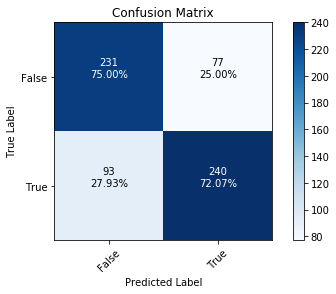

In [205]:
plot_confusion_matrix(confusion_matrix(y_test, pred), ['False', 'True'])